<a href="https://colab.research.google.com/github/amanjain487/tsai-eva6/blob/main/Assignments/S6/group_norm_with_l1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt
from model_norm import Net


# Model Summary and Paramters
Print the model parameters and output shape at each layer by giving dummy input to torchsummary

In [3]:
!pip install torchsummary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net("group").to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
         GroupNorm-2           [-1, 32, 28, 28]              64
           Dropout-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             320
            Conv2d-6           [-1, 10, 28, 28]             900
         GroupNorm-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
              ReLU-9           [-1, 10, 28, 28]               0
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 10, 12, 12]             900
        GroupNorm-12           [-1, 10, 12, 12]              20
          Dropout-13           [-1, 10, 12, 12]               0
             ReLU-14           [-1

# Split Dataset into Train set and Test set

In [4]:
train_set = datasets.MNIST('../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                                       transforms.RandomRotation((-7.5, 7.5), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ]))


test_set = datasets.MNIST('../data', 
                   train=False, 
                   download=True,
                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ]))


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Create Data Loaders for Train and Test set

In [5]:
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)

batch_size=128

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)

# Define Train and Test Functions

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    processed = 0
    lambda_l1 = 0.0001
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        l1 = 0
        for p in model.parameters():
          l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1 * l1
        total_loss += loss
        loss.backward()
        optimizer.step()
        predictions = output.argmax(dim=1, keepdim=True)
        correct += predictions.eq(target.view_as(predictions)).sum().item()
        processed += len(data)
    training_losses.append(total_loss)
        #pbar.set_description(desc= f'Train set: Accuracy={100*correct/processed:0.1f}')
    training_accuracy.append(100*correct/processed)
    print('Loss = ', loss)
    print('L1 = ', l1)
    print('Train set: Accuracy={:0.1f}'.format(100*correct/processed))



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            predictions = output.argmax(dim=1, keepdim=True)
            correct += predictions.eq(target.view_as(predictions)).sum().item()

    test_loss /= len(test_loader.dataset)
    testing_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    testing_accuracy.append(100. * correct / len(test_loader.dataset))

# Train and Test the Model
Use LR Scheduling

In [7]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

# will be used while plotting graphs

training_losses = []
testing_losses = []
training_accuracy = []
testing_accuracy = []


model = Net("group").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 20):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


EPOCH: 1 LR =  [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss =  tensor(0.1740, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(607.1976, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=80.6
Test set: Average loss: 0.1191, Accuracy: 9702/10000 (97.0%)

EPOCH: 2 LR =  [0.01]
Loss =  tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(633.0626, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=96.5
Test set: Average loss: 0.0738, Accuracy: 9777/10000 (97.8%)

EPOCH: 3 LR =  [0.01]
Loss =  tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(644.5521, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=97.4
Test set: Average loss: 0.0657, Accuracy: 9804/10000 (98.0%)

EPOCH: 4 LR =  [0.01]
Loss =  tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(646.8822, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=97.9
Test set: Average loss: 0.0467, Accuracy: 9865/10000 (98.7%)

EPOCH: 5 LR =  [0.01]
Loss =  tensor(0.1601, device='cuda:0', grad_fn=<Add

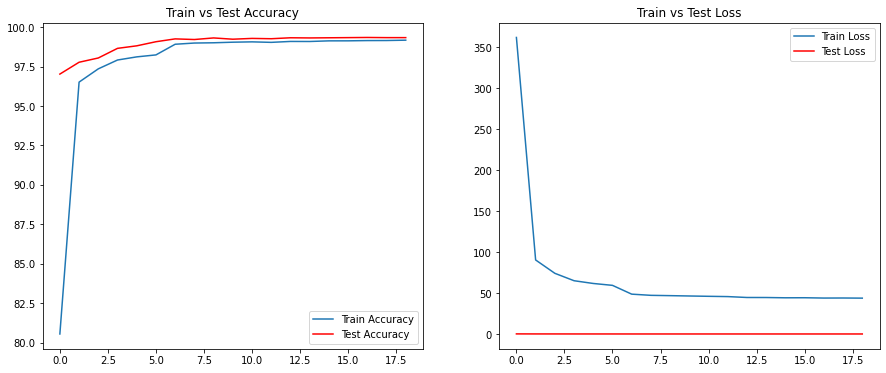

In [8]:
import numpy as np
plt.rcParams['figure.figsize'] = [15, 6]

def training_curves():
  plt.subplot(1,2, 1)

  plt.plot(np.array(training_accuracy))
  plt.plot(np.array(testing_accuracy), 'r')
  plt.legend(["Train Accuracy", "Test Accuracy"])
  plt.title("Train vs Test Accuracy")

  plt.subplot(1,2,2)
  plt.plot(training_losses)
  plt.plot(testing_losses, 'r')
  plt.legend(["Train Loss", "Test Loss"])
  plt.title("Train vs Test Loss")

training_curves()